# Hugging face
Hugging Face 是一家專注於 NLP、GenAI 的公司，提供強大且易用的工具、模型和數據集。它的核心產品是 Transformers 庫，目前已擴展到支援各種機器學習應用。

Hugging Face 的目標是讓 NLP 和生成式 AI 更加開放與普及，方便用戶快速開發與部署模型。(kinda like Github)

In [ ]:
# !pip install transformers==4.28.0 update to 4.46.2
!pip install transformers --upgrade

In [ ]:
!pip install datasets --upgrade # Hugging Face 提供，用於處理各種 NLP 資料集。

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# HuggingFace API 有良好相容性

import numpy as np
import pandas as pd
import os
import math

# transformers library: 提供了大規模預訓練模型（BERT、GPT、T5 等）的工具，支援多種任務和框架（PyTorch、TensorFlow、JAX）
from transformers import BertTokenizer # 文字轉為BERT的輸入格式（Token IDs），支援文本分詞、截斷、填充，以及添加特殊標記 [CLS] 和 [SEP]。
from transformers import Trainer # Hugging Face 提供的 API，簡化了模型訓練和評估流程。
from transformers import BertForSequenceClassification # 專門針對 BERT 模型的序列分類任務。
from transformers import TrainingArguments # 設置訓練過程的超參數（Hyperparameters），如學習率、批次大小、訓練輪數等。影響模型的訓練過程，而不是模型架構本身。
from transformers import pipeline # 提供高階工具，用於快速推理任務，例如情緒分析、文本生成。

# datasets: 數據處理和管理工具
from datasets import Dataset # 用於數據加載、分批、預處理，支援流式處理大數據。

# Pytorch
import torch

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
# check version
import transformers
torch.__version__, transformers.__version__

('2.5.1+cu121', '4.46.2')

In [ ]:
torch.cuda.is_available() # 執行階段 -> 變更執行階段 -> GPU

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/1.csv'

# 使用 pandas 讀取 CSV 文件
df = pd.read_csv(file_path)
df = df.loc[:, ~df.columns.str.startswith('Unname')]
print(df.head(),"\n")
print(df["label"].value_counts())

                                            sentence  label
0  $2.26 Billion Growth in Global Smart Waste Man...      2
1  NEW YORK, March 25, 2021 /PRNewswire/ -- Techn...      0
2  The market is segmented by application (collec...      0
3  The report offers an in-depth analysis of rece...      0
4                   Download Sample Report Instantly      0 

label
0    18
2     6
1     2
Name: count, dtype: int64


In [ ]:
from datasets import load_dataset # 用於加載 NLP 數據集。
from transformers import AutoConfig # 設置模型架構的內部配置（Configuration），如標籤數量、隱藏層大小、激活函數等。
from transformers import AutoModelForSequenceClassification # 自動識別模型類型，支援多種模型（如 BERT、RoBERTa、DistilBERT、DeBERTa..)

# 模型預測的值，映射回分類結果
id2label = {
    "0": "Neutral",
    "1": "Positive",
    "2": "Negative"
  }

# 分類結果映射成數值
label2id = {
    "Neutral": 0,
    "Positive": 1,
    "Negative": 2
  }


# 指定使用的模型，
model = BertForSequenceClassification.from_pretrained( # 基於 BERT 預訓練模型的基礎，新增了一個分類層
    'bert-base-cased', # "cased" 表示區分大小寫
    num_labels=3, # 三分類問題
    label2id=label2id, # 定義 label編碼和label解碼方式
    id2label=id2label
)

# BertTokenizer: 將輸入的文字轉換成數值化的詞彙ID，將文字拆分為子詞單元（subwords），例如 "running" 會被拆成 "run" 和 "##ning"。
# 分詞器和模型需要配合使用，確保文本數據可以被正確地轉換為模型輸入格式。
tokenizer = BertTokenizer.from_pretrained('bert-base-cased') # 加載模型（包含權重和配置）

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# 測試
text = "Hello world." # ['[CLS]', 'Hello', 'world', '.', '[SEP]']
tokens = tokenizer(text, return_tensors="pt")  # 返回 PyTorch 格式的張量
print(tokens)
# input_ids：表示子詞對應的ID。
# token_type_ids：標記句子邊界，0:第一句，1:第二句。
# attention_mask：指出哪些位置是有效的，哪些是補全的（0 表示忽略，1 表示有效）。

text_1 = "Hello world."
text_2 = "World Hello!"
text_3 = ["Hello world.", "World Hello!"]
tokens = tokenizer(text_1, text_2, return_tensors="pt")
token2 = tokenizer(text_3, return_tensors="pt")
print(tokens)
print(token2)


{'input_ids': tensor([[ 101, 8667, 1362,  119,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
{'input_ids': tensor([[ 101, 8667, 1362,  119,  102, 1291, 8667,  106,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
{'input_ids': tensor([[ 101, 8667, 1362,  119,  102],
        [ 101, 1291, 8667,  106,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])}


In [ ]:
list(df.columns)

['sentence', 'label']

In [ ]:
# stratify=df['label']: 分割後，label類別的比例與原始數據集中保持一致。
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42) # 全部數據切90%給訓練集
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42) # 剛剛切的10%做驗證集
print(df_train.shape, df_test.shape, df_val.shape) # (rows, columns)

(20, 2) (3, 2) (3, 2)


In [ ]:
# 將 Pandas DataFrame 轉換為 Hugging Face 的 Dataset object
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

print(dataset_train)

dataset_train = dataset_train.remove_columns(["__index_level_0__"])
dataset_val = dataset_val.remove_columns(["__index_level_0__"])
dataset_test = dataset_test.remove_columns(["__index_level_0__"])

print(dataset_train)


Dataset({
    features: ['sentence', 'label', '__index_level_0__'],
    num_rows: 20
})
Dataset({
    features: ['sentence', 'label'],
    num_rows: 20
})


In [ ]:
# 如果句子的長度超過 max_length，進行 truncate，如果少於則進行 padding，並使用批次處理
# map 可以使用 batch 處理，以及把結果併回原資料後，return 新的 Dataset
dataset_train = dataset_train.map(lambda x: tokenizer(x['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda x: tokenizer(x['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda x: tokenizer(x['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)
print(dataset_train, "\n", type(dataset_train),"\n", "-------")

# 將 Dataset 中的數據轉換為指定的格式(tensor)，並指定要轉的欄位
# set_format 方法僅設定了數據的返回格式。只有從 Dataset 中取出數據時，它才會以指定的格式返回對應的數據。
dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
print(dataset_train[0])

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 20
}) 
 <class 'datasets.arrow_dataset.Dataset'> 
 -------
{'label': tensor(2), 'input_ids': tensor([  101,  1636,  5320,  1132,  2637,  1106,  1501,  1317,  6305,  1111,
         2319, 19086,  1219,  1103, 24647,  1669,   119,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# 執行 trainer.evaluate() 或 trainer.train()（在有評估的情況下）時，Trainer 會自動執行評估邏輯，並調用提供的 compute_metrics 函數來計算評估指標。
def compute_metrics(eval_pred): # eval_pred 由 predictions 以及 labels 組成。
    """
    計算模型的評估指標，包括準確率（accuracy）、F1 分數、精確率（precision）和召回率（recall）。
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) # predictions 是未經處理的每個類別的分數
    # average='weighted'：按每個類別的樣本數加權平均， zero_division=0: 防止精確率或召回率的分母為 0 時報錯，改為返回 0。
    precision, recall, f1, _ = precision_recall_fscore_support(labels.flatten(), predictions.flatten(), average='weighted', zero_division=0)

    return {'accuracy' : accuracy_score(predictions, labels), # 計算準確率
         'f1': f1,
         'precision': precision,
         'recall': recall
            }


# Debug: 更新 evaluation_strategy 為 eval_strategy。
# 不使用 Hugging Face Trainer 自動記錄訓練過程到 W&B 平台的功能

args = TrainingArguments( # 訓練過程中的超參數設定
        output_dir = 'temp/', # 在哪裡保存訓練過程中的輸出內容
        eval_strategy = 'epoch', # 模型的評估頻率
        save_strategy = 'epoch', # 模型保存的頻率
        learning_rate=2e-5, # 2 * (10 ** -5)
        per_device_train_batch_size=32, # 訓練批次大小(CPU/GPU)
        per_device_eval_batch_size=32, # 評估批次大小(CPU/GPU)
        num_train_epochs=5, # 訓練的週期數
        # L2正則化會將一個懲罰項（與模型權重相關的值）添加到損失函數中，在訓練過程中，模型會被強迫減小權重的大小，因為較大的權重會導致損失函數變大。權重越小，模型越簡單，泛化性能越好。)
        weight_decay=0.01, # L2 正則化的權重衰減參數，用於減少OVERFIITING。
        load_best_model_at_end=True, # 訓練結束時，自動加載表現最佳的模型（基於指定的評估指標）
        metric_for_best_model='accuracy', # 最佳模型的評估指標
        report_to='none'  # 禁用 W&B
)


trainer = Trainer( # 定義模型訓練的完整流程
        model=model,
        args=args, # 訓練的超參數，來自 TrainingArguments
        train_dataset=dataset_train,
        eval_dataset=dataset_val,
        compute_metrics=compute_metrics # eval_pred 是由 Trainer 自動生成的，包含模型預測結果和真實標籤。
)
no_deprecation_warning=True # 如果 Trainer 使用了過時的參數或方法，HuggingFace 會顯示警告。現在讓它隱藏這些提示。
trainer.train() # 啟動訓練

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.056800,0.666667,0.533333,0.444444,0.666667
2,No log,0.961942,0.666667,0.533333,0.444444,0.666667
3,No log,0.945050,0.666667,0.533333,0.444444,0.666667
4,No log,0.933252,0.666667,0.533333,0.444444,0.666667
5,No log,0.923607,0.666667,0.533333,0.444444,0.666667


TrainOutput(global_step=5, training_loss=0.9246418952941895, metrics={'train_runtime': 57.0678, 'train_samples_per_second': 1.752, 'train_steps_per_second': 0.088, 'total_flos': 6577835443200.0, 'train_loss': 0.9246418952941895, 'epoch': 5.0})

In [ ]:
# model.eval() # 將模型切換到評估模式，此狀態下會關閉Dropout層 (可省略，Trainer 會自動切換)


# 對測試集數據進行預測，Trainer.predict 的輸出是 PredictionOutput object，包含預測結果、真實標籤、評估指標
prediction_output = trainer.predict(dataset_test)
print(prediction_output, "\n")

# 提取指標
metrics = prediction_output.metrics
print(metrics)


PredictionOutput(predictions=array([[ 0.4176735 ,  0.29710063, -0.371876  ],
       [ 0.36828586,  0.20514432, -0.2981875 ],
       [ 0.3383393 ,  0.22112261, -0.30598584]], dtype=float32), label_ids=array([2, 0, 0]), metrics={'test_loss': 1.127092957496643, 'test_accuracy': 0.6666666666666666, 'test_f1': 0.5333333333333333, 'test_precision': 0.4444444444444444, 'test_recall': 0.6666666666666666, 'test_runtime': 0.0455, 'test_samples_per_second': 65.913, 'test_steps_per_second': 21.971}) 

{'test_loss': 1.127092957496643, 'test_accuracy': 0.6666666666666666, 'test_f1': 0.5333333333333333, 'test_precision': 0.4444444444444444, 'test_recall': 0.6666666666666666, 'test_runtime': 0.0455, 'test_samples_per_second': 65.913, 'test_steps_per_second': 21.971}


In [ ]:
trainer.save_model('/content/drive/MyDrive/Colab Notebooks/BERT123')

`config.json`: 模型的配置檔案，包含架構、超參數等信息。<br>
`pytorch_model.bin`: 模型的權重檔案，包含所有經過訓練後的參數（PyTorch 格式）。<br>
`model.safetensors`: 模型權重文件，它是 Hugging Face 支援的一種更安全和高效的文件格式，用來替代傳統的 pytorch_model.bin 文件。

In [ ]:
m = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/BERT123")
print(m.config.id2label)

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}


In [ ]:
# file_path = 'C:\\Users\\88697\\Downloads\\AINews_label\\1.csv'
# data = pd.read_csv(file_path, encoding='ISO-8859-1')


# testing data
file_path = r"/content/drive/MyDrive/Colab Notebooks/1.csv"
data = pd.read_csv(file_path)

# 定義將數字標籤轉換為情緒標籤的函數
def convert_label(numeric_label):
    label_map = {0: 'Neutral', 1: 'Negative', 2: 'Positive'}
    return label_map[numeric_label]

print(f"Testing: {convert_label(1)}")
print(data)

# 轉換所有相關列的數字標籤
label_columns = ['researcher label', 'ChatGPT label', 'researcher2 label', "label"]
for column in label_columns:
    if column in data.columns:
        data[column] = data[column].apply(convert_label)


print(data)

# 保存更新後的 DataFrame
file_path = r"/content/drive/MyDrive/Colab Notebooks/1_update.csv"
data.to_csv(file_path, index=False)


Testing: Negative
                                             sentence  label
0   $2.26 Billion Growth in Global Smart Waste Man...      2
1   NEW YORK, March 25, 2021 /PRNewswire/ -- Techn...      0
2   The market is segmented by application (collec...      0
3   The report offers an in-depth analysis of rece...      0
4                    Download Sample Report Instantly      0
5         Smart Waste Management Market: Key Findings      0
6       Smart Waste Management Market: Growth Drivers      0
7   Growing industrial waste is one of the prime f...      2
8   Rapid urbanization and industrialization acros...      1
9   Besides, the growing stringency of regulations...      2
10  These factors are expected to open several opp...      2
11  Growing investments in smart waste recycling a...      2
12  Develop Smart Strategies for Your Business: Ge...      0
13  Smart Waste Management Market: Major Vendors B...      0
14  operates its business through the Unified segm...      0
15  Th

In [ ]:
# data = pd.read_csv('C:\\Users\\88697\\Downloads\\AINews_label\\Total_data.csv', usecols=[1], encoding='ISO-8859-1').values
# data2 = pd.read_csv('C:\\Users\\88697\\Downloads\\AINews_label\\Total_data.csv', encoding='ISO-8859-1', index_col=False)
# nlp = pipeline("text-classification", model=bertFP, tokenizer=tokenizer)
# lst=[]
# for x in range(len(data)):
#   string = np.array_str(data[x])
#   print(string)
#   results = nlp(string)
#   print(x+1, results)
#   string = ''.join(map(str, results))
#   if "Positive" in string:
#       p='Positive'
#       lst.append(p)
#   elif "Negative" in string:
#       n='Negative'
#       lst.append(n)
#   elif "Neutral" in string:
#       u='Neutral'
#       lst.append(u)
# for x in range(len(lst)):
#     data2.at[x, 'BERT Label'] = lst[x]
# df = pd.DataFrame(data2)
# df.to_csv('C:\\Users\\88697\\Downloads\\AINews_label\\Total_data.csv', index=False)
# df

In [ ]:
import pandas as pd
import numpy as np
from transformers import pipeline

file_path = r'/content/drive/MyDrive/Colab Notebooks/1_update.csv'
data = pd.read_csv(file_path)


# 剛剛訓練的模型在下載時也需要用相同的類別（BertForSequenceClassification）來確保模型結構與權重匹配。
bertFP = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/BERT123')
# 分詞器和模型需要配合使用，確保文本數據可以被正確地轉換為模型輸入格式。
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


# pipline(): 用於快速構建基於預訓練模型的 NLP 管道,(自動處理分詞 → 推理 → 結果解析)
nlp = pipeline("text-classification", model=bertFP, tokenizer=tokenizer, batch_size=16) # device=0(GPU), device=1(CPU)

# 測試
text = "Hello, world!"
results = nlp(text)
print(results, "======================================================================") # [{'label': 'Positive', 'score': 0.46}]




# 定義批量處理函數
def classify_texts(texts):
    """用bert跑情緒分析"""
    results = nlp(texts)
    labels = [result['label'] for result in results]
    return labels


data['sentence'] = data['sentence'].fillna("").astype(str)

# 分批跑BERT
# BERT 接受的輸入1: 單句 text = "This is a great day!"
# BERT 接受的輸入2: 多句 text = ["This is a great day!", "No it,s not!"]
batch_size = 16
labels = []
for i in range(0, len(data), batch_size): # optional: 保護內存
    batch_texts = data['sentence'][i:i+batch_size].tolist() # BERT 接受的輸入2
    print(len(batch_texts), batch_texts) # Check
    try:
      batch_labels = classify_texts(batch_texts)
    except Exception as e:
      print(f"Error in batch {i}: {e}")
      batch_labels = ["Error"] * len(batch_texts) # 避免跳行
    labels.extend(batch_labels) # 將每個元素「逐一」加到列表中。

print(labels)


data['BERT Label'] = labels

file_path = r"/content/drive/MyDrive/Colab Notebooks/1_update_2.csv"
data.to_csv(file_path, index=False)



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'Positive', 'score': 0.4695723056793213}] ======================================================================
16 ['$2.26 Billion Growth in Global Smart Waste Management Market During 2021-2025 | Featuring Key Vendors Including Bigbelly Inc., Compology, and Contelligent | Technavio', 'NEW YORK, March 25, 2021 /PRNewswire/ -- Technavio announces the release of its latest report on the smart waste management market.', 'The market is segmented by application (collection, landfill, recovery and recycling, and processing) and geography (Europe, APAC, North America, South America, and MEA).', 'The report offers an in-depth analysis of recent developments, changes in market regulations, product approvals, product launches, and the market behavior across various segments.', 'Download Sample Report Instantly', 'Smart Waste Management Market: Key Findings', 'Smart Waste Management Market: Growth Drivers', 'Growing industrial waste is one of the prime factors driving the growth of th

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

file_path = r"/content/drive/MyDrive/Colab Notebooks/1_update_2.csv"
data = pd.read_csv(file_path)


# 預測錯誤
mismatches = data['label'] != data['BERT Label']
mismatch_count = mismatches.sum()
data_count = len(data['label'])



accuracy = accuracy_score(data['label'], data['BERT Label'])
precision = precision_score(data['label'], data['BERT Label'], average='macro')
recall = recall_score(data['label'], data['BERT Label'], average='macro')
f1 = f1_score(data['label'], data['BERT Label'], average='macro')


print(f"Number of data: {data_count}")
print(f"Number of mismatches: {mismatch_count}")
print(f"Accuracy of the model predictions: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Number of data: 26
Number of mismatches: 9
Accuracy of the model predictions: 0.65
Precision: 0.34
Recall: 0.35
F1 Score: 0.33


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


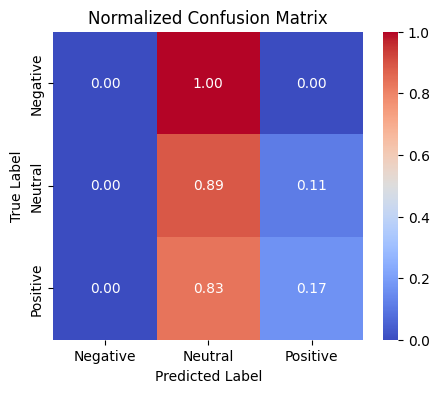

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


file_path = r"/content/drive/MyDrive/Colab Notebooks/1_update_2.csv"
data = pd.read_csv(file_path)


# 計算混淆矩陣
conf_matrix = confusion_matrix(data['label'], data['BERT Label'], normalize='true')

# 使用 seaborn 繪製熱圖
plt.figure(figsize=(5, 4))
sns.heatmap(
    conf_matrix, annot=True, fmt=".2f", cmap='coolwarm',
    xticklabels=sorted(data['label'].unique()),
    yticklabels=sorted(data['label'].unique())
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()
